In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyRegressor

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV

from yellowbrick.regressor import ResidualsPlot, PredictionError

## Carregando os dadasets

In [2]:
X_train = pd.read_csv('../data/X_train.csv')
y_train = pd.read_csv('../data/y_train.csv').squeeze()

X_test = pd.read_csv('../data/X_test.csv')
y_test = pd.read_csv('../data/y_test.csv').squeeze()

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'-' * 27)
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (11591, 59)
y_train shape: (11591,)
---------------------------
X_test shape: (4968, 59)
y_test shape: (4968,)


## Construindo e Treinando o Módelo

Fazendo uma busca para encontrar o modelo com o melhor desempenho, tendo o criterio de pontuação o MSE.

In [3]:
pipeline = Pipeline([
    ('rgs', DummyRegressor())
])

grid_values = [
    {
        'rgs': [LinearRegression()]
    },
    {
        'rgs': [BaggingRegressor(base_estimator=RandomForestRegressor())],
    },
    {
        'rgs': [RandomForestRegressor()],
        'rgs__criterion': ['squared_error', 'absolute_error', 'poisson']
    },
    {
        'rgs': [AdaBoostRegressor(base_estimator=RandomForestRegressor(n_estimators=1))],
        'rgs__loss': ['linear', 'square', 'exponential']
    },
    {
        'rgs': [AdaBoostRegressor(base_estimator=RandomForestRegressor(n_estimators=2))],
        'rgs__loss': ['linear', 'square', 'exponential']
    },
    {
        'rgs': [AdaBoostRegressor(base_estimator=RandomForestRegressor(n_estimators=3))],
        'rgs__loss': ['linear', 'square', 'exponential']
    },
    {
        'rgs': [GradientBoostingRegressor()],
        'rgs__loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
        'rgs__criterion': ['friedman_mse', 'squared_error']
    },
]

grid_search = GridSearchCV(pipeline, grid_values, scoring='neg_mean_squared_error', verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 22 candidates, totalling 110 fits
[CV 1/5] END ...........rgs=LinearRegression();, score=-0.072 total time=   0.1s
[CV 2/5] END ...........rgs=LinearRegression();, score=-0.067 total time=   0.1s
[CV 3/5] END ...........rgs=LinearRegression();, score=-0.068 total time=   0.1s
[CV 4/5] END ...........rgs=LinearRegression();, score=-0.066 total time=   0.1s
[CV 5/5] END ...........rgs=LinearRegression();, score=-0.069 total time=   0.1s
[CV 1/5] END rgs=BaggingRegressor(base_estimator=RandomForestRegressor());, score=-0.022 total time=  43.4s
[CV 2/5] END rgs=BaggingRegressor(base_estimator=RandomForestRegressor());, score=-0.021 total time=  42.8s
[CV 3/5] END rgs=BaggingRegressor(base_estimator=RandomForestRegressor());, score=-0.022 total time=  42.3s
[CV 4/5] END rgs=BaggingRegressor(base_estimator=RandomForestRegressor());, score=-0.021 total time=  41.1s
[CV 5/5] END rgs=BaggingRegressor(base_estimator=RandomForestRegressor());, score=-0.022 total time= 

GridSearchCV(estimator=Pipeline(steps=[('rgs', DummyRegressor())]),
             param_grid=[{'rgs': [LinearRegression()]},
                         {'rgs': [BaggingRegressor(base_estimator=RandomForestRegressor())]},
                         {'rgs': [RandomForestRegressor()],
                          'rgs__criterion': ['squared_error', 'absolute_error',
                                             'poisson']},
                         {'rgs': [AdaBoostRegressor(base_estimator=RandomForestRegressor(n_estimators=1))]...
                          'rgs__loss': ['linear', 'square', 'exponential']},
                         {'rgs': [AdaBoostRegressor(base_estimator=RandomForestRegressor(n_estimators=3),
                                                    loss='square')],
                          'rgs__loss': ['linear', 'square', 'exponential']},
                         {'rgs': [GradientBoostingRegressor()],
                          'rgs__criterion': ['friedman_mse', 'squared_error'],
                          'rgs__loss': ['squared_error', 'absolute_error',
                                        'huber', 'quantile']}],
             scoring='neg_mean_squared_error', verbose=3)

Visualizando qual foi o melhor modelo

In [4]:
grid_search.best_estimator_

Pipeline(steps=[('rgs',
                 AdaBoostRegressor(base_estimator=RandomForestRegressor(n_estimators=3),
                                   loss='square'))])

A pontuação desse melhor modelo

In [5]:
grid_search.best_score_

-0.016266828297613067

Os parametros desse melhor modelo

In [6]:
grid_search.best_params_

{'rgs': AdaBoostRegressor(base_estimator=RandomForestRegressor(n_estimators=3),
                   loss='square'),
 'rgs__loss': 'square'}

In [7]:
model = grid_search.best_estimator_

## Avaliação do Módelo

/home/enacom/.virtualenvs/py3cv4/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


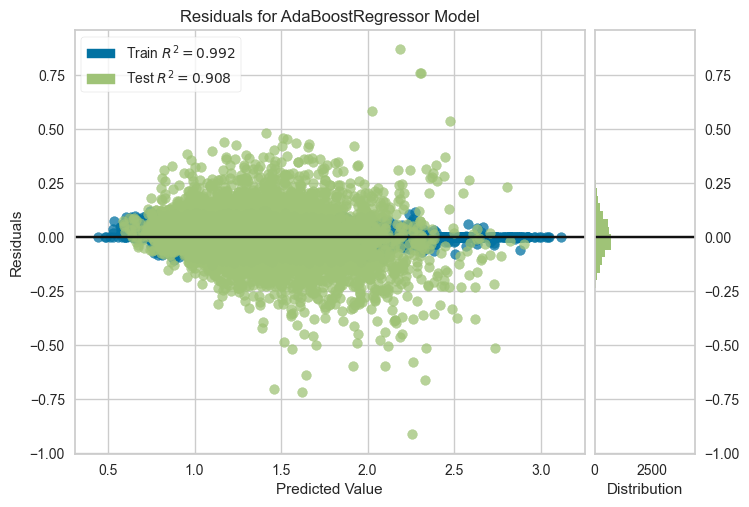

<AxesSubplot: title={'center': 'Residuals for AdaBoostRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [8]:
visualizer = ResidualsPlot(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

Visualizando os residuais, podemos perceber que durante o treino o modelo obteve um excelente desempenho, com os valores residuais bem proximos de zero. Ja no teste temos uma dispersão um pouco maior, porem é uma dispersão equilibrada, tanto para cima quanto para baixo. Também da para notar que o modelo tem uma tendencia de predizer valores mais baixos no teste, o espaço a partir de 2.5 no valor previsto consta com poucas predições.

/home/enacom/.virtualenvs/py3cv4/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


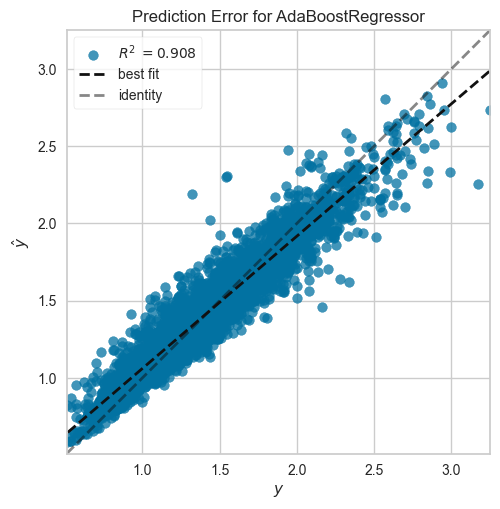

<AxesSubplot: title={'center': 'Prediction Error for AdaBoostRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [9]:
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

Visualizando o erro, podemos perceber que a maioria dos valores estão proximos da linha diagonal, porem, percebe-se também que o modelo encontra mais dificuldade para predizer valores altos, de 2.5 pra cima começa a se perceber uma dispersão maior do erro.